In [1]:
#Import libraries 

import numpy as np
import cv2 as cv
import os
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1000) # helps with repeatable results
os.environ['KERAS_BACKEND'] = 'tensorflow' # Added to set the backend as Tensorflow

In [3]:
image_directory = 'cell_images/'
size = 64
dataset = [] # Handle data with list format
label = [] # placeholders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [4]:
parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images): #Iterate through all images in Parasitized folder
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB') # convert it to a Pillow image
        image = image.resize((size,size)) # resize to 64 x 64
        dataset.append(np.array(image)) #  save into the same numpy array 'dataset' but with label 0
        label.append(0)


uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images): #Iterate through all images in Uninfected folder
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size,size)) # resize to 64 x 64
        dataset.append(np.array(image)) #  save into the same numpy array 'dataset' but with label 1
        label.append(1)

In [5]:
# Building the model (2 conv and pool layers) with some normalization and drops in between
input_shape = (size, size, 3)
inp = keras.layers.Input(shape=input_shape)

conv1 = keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
norm1 = keras.layers.BatchNormalization(axis=-1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)

conv2 = keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
norm2 = keras.layers.BatchNormalization(axis=-1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis=-1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)

hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis=-1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation = 'sigmoid')(drop4) #units=1 gives error
#print('done')
model = keras.Model(inputs=inp, outputs=out) # Define the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Check between binary_crossentropy and categorical_crossentropy
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

In [7]:
#Split the dataset
x_train, x_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size=0.2, random_state=0) 
# to_categorical => converts array into a binary calss matrix


In [8]:
# Fitting the model
history = model.fit(np.array(x_train), y_train, batch_size=64, verbose=1, epochs=50, validation_split=0.1, shuffle=False)

Epoch 1/50
311/311 [==============================] - 80s 252ms/step - loss: 0.5716 - accuracy: 0.7407 - val_loss: 1.5416 - val_accuracy: 0.7356
Epoch 2/50
311/311 [==============================] - 79s 255ms/step - loss: 0.2518 - accuracy: 0.9066 - val_loss: 0.2970 - val_accuracy: 0.9102
Epoch 3/50
311/311 [==============================] - 79s 255ms/step - loss: 0.2015 - accuracy: 0.9268 - val_loss: 0.2083 - val_accuracy: 0.9270
Epoch 4/50
311/311 [==============================] - 80s 259ms/step - loss: 0.1765 - accuracy: 0.9354 - val_loss: 0.3919 - val_accuracy: 0.8299
Epoch 5/50
311/311 [==============================] - 80s 257ms/step - loss: 0.1587 - accuracy: 0.9418 - val_loss: 0.1940 - val_accuracy: 0.9288
Epoch 6/50
311/311 [==============================] - 78s 250ms/step - loss: 0.1478 - accuracy: 0.9459 - val_loss: 0.1746 - val_accuracy: 0.9392
Epoch 7/50
311/311 [==============================] - 80s 257ms/step - loss: 0.1329 - accuracy: 0.9511 - val_loss: 0.1503 - val_ac

In [9]:
# Accuracy Calculation
print('Test_Accuracy: {:.2f}%'.format(model.evaluate(np.array(x_test), np.array(y_test))[1]*100))

173/173 [==============================] - 3s 16ms/step - loss: 0.3100 - accuracy: 0.9485
Test_Accuracy: 94.85%


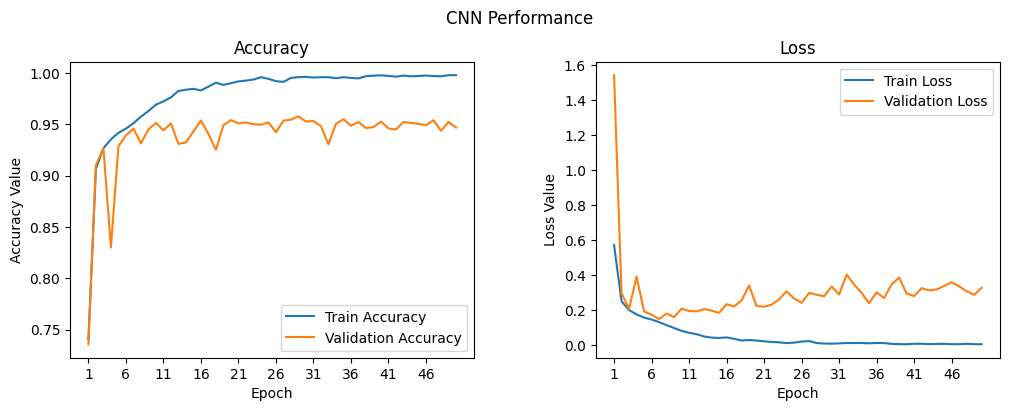

In [10]:
## Plotting and Printing the performences
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [11]:
## Saving the model
model.save('Results/malaria_cnn_50.h5')